# Iteration 1: A simple model with one type of unplanned admission

In order to simplify the model, we will first assume that patients only arrive from one source – we will take this to be A&E and use the given interrarival times and length of stay for this pathway.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import simpy
import warnings
from scipy.stats import t
from sim_tools.distributions import Exponential, Lognormal

## Model Classes

We will use a similar object orientated approach for healthcare modelling in SimPy to the one recommended in the [HSMA little book of DES](https://des.hsma.co.uk/), making use of three main classes

* `CritCarePt`, a class used to store information about the patients in the system.
* `CritCareUnit`, a class representing the CCU system being modelled, in which the SimPy environment and generators are kept.
* `ScenarioTrial`, a class representing a batch of runs of a simulation with specific parameter settings.

### The `CritCarePt` class

Let's start by coding a simple class representing patients who are admitted to the unit.

In [2]:
class CritCarePt:
    """
    Represents a patient in the system.

    Attributes
    ----------
    id : int
        Unique patient identifier.
    queue_time : float
        Time the patient spent waiting for a bed in hours.
    time_in_ccu : float
        Actual time the patient spent occupying a bed during the simulation.
    """
    def __init__(self, p_id):
        """
        Initialise a new patient.
        """
        self.id = p_id
        self.queue_time = 0
        self.time_in_ccu = 0

### The `CritCareUnit` class

We now move on to the `CritCareUnit` class.

In [3]:
class CritCareUnit:
    """
    Discrete-event simulation of the system.

    Attributes
    ----------
    run_number : int
        Seed used to reproduce a specific run.
    mean_ia : float
        Mean inter-arrival time between patients in hours.
    mean_len_stay : float
        Mean length of stay for a patient in hours.
    stdev_len_stay : float
        Standard deviation of the length-of-stay distribution.
    num_beds : int
        Number of CCU beds available.
    sim_duration : float
        Duration of the simulation after the warm-up period.
    warm_up : float
        Warm-up period duration in hours
        (results collected only after this time).
    first_patient_post_warm_up : int
        The identifier of the first patient to be included in results
        calculations following the warm-up period.
    env : simpy.Environment
        The SimPy simulation environment.
    patient_counter : int
        Running count of patients who have arrived.
    sim_pt_objects : list of CritCarePt
        Patient objects created after the warm-up period.
    bed : simpy.Resource
        SimPy resource representing the pool of beds.
    results_df : pandas.DataFrame
        Per-patient results (Queue Time, Length of Stay).
    mean_queue_time : float
        Mean queue time across all post-warm-up patients.
    bed_utilisation : float
        Average bed utilisation as a percentage.
    inter_arrival_dist : Exponential
        Exponential distribution used to sample inter-arrival times.
    len_stay_dist : Lognormal
        Lognormal distribution used to sample lengths of stay.
    """
    def __init__(self, run_number, mean_interarrival_time,
                 mean_length_of_stay, length_of_stay_std_dev,
                 number_of_beds, simulation_duration, warm_up_period):
        """
        Initialise the simulation model.
        """
        self.run_number = run_number
        self.mean_ia = mean_interarrival_time
        self.mean_len_stay = mean_length_of_stay
        self.stdev_len_stay = length_of_stay_std_dev
        self.num_beds = number_of_beds
        self.sim_duration = simulation_duration
        self.warm_up = warm_up_period
        self.env = simpy.Environment()
        self.patient_counter = 0
        self.first_patient_post_warm_up = 0
        self.sim_pt_objects = []
        self.bed = simpy.Resource(self.env, capacity=self.num_beds)
        self.results_df = pd.DataFrame()
        self.results_df["Patient ID"] = [1]
        self.results_df["Queue Time"] = [0.0]
        self.results_df["Length of Stay"] = [0.0]
        self.results_df.set_index("Patient ID", inplace=True)
        self.mean_queue_time = 0.0
        self.bed_utilisation = 0.0
        ss = np.random.SeedSequence(self.run_number)
        seeds = ss.spawn(2)
        self.inter_arrival_dist = Exponential(mean=mean_interarrival_time,
                                              random_seed=seeds[0])
        self.len_stay_dist = Lognormal(mean=mean_length_of_stay,
                                       stdev=length_of_stay_std_dev,
                                       random_seed=seeds[1])

    def generate_patient_referrals(self):
        """
        Generate arriving patients.

        Each iteration increments the patient counter, spawns an admission
        process for the new patient, then waits for a
        sampled inter-arrival time before looping.
        """
        while True:
            self.patient_counter += 1
            p = CritCarePt(self.patient_counter)
            self.env.process(self.admit_unit(p))
            sampled_inter = self.inter_arrival_dist.sample()
            yield self.env.timeout(sampled_inter)

    def admit_unit(self, patient):
        """
        Models a single patient's admission.

        The patient queues for a bed, occupies it for a sampled length of
        stay, and then releases it.  Results are only recorded after the
        warm-up period has elapsed.

        Parameters
        ----------
        patient : CritCarePt
            The patient object to process.
        """
        start_q_bed = self.env.now
        with self.bed.request() as req:
            yield req
            end_q_bed = self.env.now
            patient.queue_time = end_q_bed - start_q_bed
            sampled_len_stay = self.len_stay_dist.sample()
            sim_time_remain = self.sim_duration + self.warm_up - self.env.now
            len_stay_before_end_sim = min(sampled_len_stay, sim_time_remain)
            patient.time_in_ccu = len_stay_before_end_sim
            if self.env.now > self.warm_up:
                self.results_df.at[patient.id, "Queue Time"] = (
                    patient.queue_time)
                self.results_df.at[patient.id, "Length of Stay"] = (
                    sampled_len_stay)
                self.sim_pt_objects.append(patient)
            yield self.env.timeout(sampled_len_stay)

    def audit_bed_utilisation(self):
        """
        Calculate bed utilisation as a percentage.

        Utilisation is computed as the total occupied bed-time divided by
        the total available bed-time (beds × simulation duration), expressed
        as a percentage.

        Returns
        -------
        float
            Bed utilisation percentage.
        """
        treatment_durations = [i.time_in_ccu for i in self.sim_pt_objects]
        return (sum(treatment_durations) * 100
                / (self.num_beds * self.sim_duration))

    def calculate_run_results(self):
        """
        Aggregate per-run summary statistics.

        Removes the placeholder row from results_df, then computes
        mean queue time, mean length of stay, and bed utilisation for the
        run.
        """
        self.results_df.drop([1], inplace=True)
        self.first_patient_post_warm_up = min(self.results_df.index)
        self.mean_queue_time = self.results_df["Queue Time"].mean()
        self.mean_len_stay = self.results_df["Length of Stay"].mean()
        self.bed_utilisation = self.audit_bed_utilisation()

    def run(self):
        """
        Execute the simulation.

        Registers the patient-arrival generator with the SimPy environment,
        runs the simulation for warm_up + sim_duration hours, then
        calculates summary results.
        """
        self.env.process(self.generate_patient_referrals())
        self.env.run(until=(self.sim_duration + self.warm_up))
        self.calculate_run_results()

### The `ScenarioTrial` class

Finally, we implement a simple `ScenarioTrial` class.

In [4]:
class ScenarioTrial:
    """
    Runs multiple replications of a simulation of the CCU system for a fixed
    scenario.

    Attributes
    ----------
    num_reps : int
        Number of simulation replications to run.
    mean_ia : float
        Mean inter-arrival time in hours passed to each replication.
    mean_len_stay : float
        Mean length of stay in hours passed to each replication.
    stdev_len_stay : float
        Standard deviation of length of stay.
    num_beds : int
        Number of beds passed to each replication.
    sim_duration : float
        Simulation duration per replication in hours.
    warm_up : float
        Warm-up period per replication in hours.
    run_results_dict : dict
        Maps replication labels to their per-patient results DataFrames.
    trial_results_df : pandas.DataFrame
        One row per replication with mean queue time and bed utilisation.
    """
    def __init__(self, number_of_reps, mean_interarrival_time,
                 mean_length_of_stay, length_of_stay_std_dev,
                 number_of_beds, simulation_duration, warm_up_period):
        """
        Initialise the trial.
        """
        self.num_reps = number_of_reps
        self.mean_ia = mean_interarrival_time
        self.mean_len_stay = mean_length_of_stay
        self.stdev_len_stay = length_of_stay_std_dev
        self.num_beds = number_of_beds
        self.sim_duration = simulation_duration
        self.warm_up = warm_up_period
        self.run_results_dict = {}
        self.trial_results_df = pd.DataFrame()
        self.trial_results_df["Mean Queue Time"] = [0.0]
        self.trial_results_df["Average Bed Utilisation"] = [0.0]

    def run_trial(self):
        """
        Execute all replications and populate trial_results_df.

        For each replication a new CritCareUnit object is instantiated,
        run, and its results stored.  The index of trial_results_df is
        set to 1-based replication numbers.
        """
        for run in range(self.num_reps):
            ccu_model = CritCareUnit(
                run_number=run,
                mean_interarrival_time=self.mean_ia,
                mean_length_of_stay=self.mean_len_stay,
                length_of_stay_std_dev=self.stdev_len_stay,
                number_of_beds=self.num_beds,
                simulation_duration=self.sim_duration,
                warm_up_period=self.warm_up
            )
            ccu_model.run()
            run_results = ccu_model.results_df
            self.run_results_dict[f"Replication {run+1}"] = run_results
            self.trial_results_df.loc[run, "Mean Queue Time"] \
                = [ccu_model.mean_queue_time]
            self.trial_results_df.loc[run, "Average Bed Utilisation"] \
                = [ccu_model.bed_utilisation]
        self.trial_results_df.index = np.arange(1, self.num_reps+1)
        self.trial_results_df.index.name = "Replication"

## Running the Model and Exploring the Results

In [5]:
my_trial = ScenarioTrial(
    number_of_reps=10,
    mean_interarrival_time=22.72,
    mean_length_of_stay=128.79,
    length_of_stay_std_dev=267.51,
    number_of_beds=5,
    simulation_duration=2016,
    warm_up_period=672
)
my_trial.run_trial()
trial_results = my_trial.trial_results_df
trial_results

,Mean Queue Time,Average Bed Utilisation
Replication,,
1,14.194327,79.740148
2,38.445913,67.762445
3,110.953630,73.147374
4,64.891236,84.470339
5,502.120927,89.688550
6,230.658429,81.359009
7,257.044442,95.449110
8,254.208347,69.149372
9,486.880047,85.109537


In [6]:
run_0_results = my_trial.run_results_dict["Replication 1"]
run_0_results.head(20)

,Queue Time,Length of Stay
Patient ID,,
25,0.000000,734.437760
26,0.000000,25.658144
27,0.000000,86.780475
28,10.656938,17.463928
29,19.247210,87.199474
30,38.392894,21.078560
31,15.185604,59.932651
32,0.000000,119.298750
33,2.138585,60.263865


In [7]:
all_run_results_dict = my_trial.run_results_dict
all_reps = pd.concat(all_run_results_dict.values())
all_reps

,Queue Time,Length of Stay
Patient ID,,
25,0.000000,734.437760
26,0.000000,25.658144
27,0.000000,86.780475
28,10.656938,17.463928
29,19.247210,87.199474
...,...,...
125,39.501365,75.911554
126,26.779426,7.133693
127,21.008201,12.765987


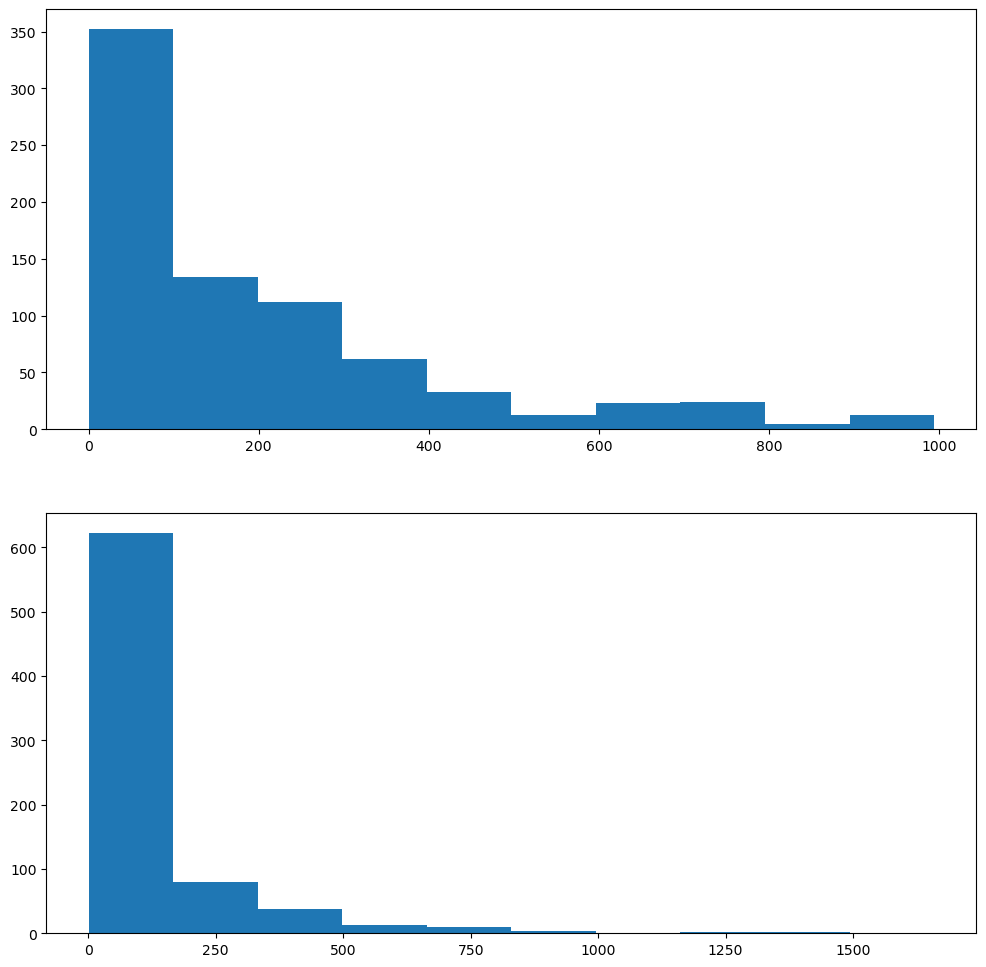

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
_ = ax[0].hist(all_reps["Queue Time"])
_ = ax[1].hist(all_reps["Length of Stay"])

## Modifying the Trial class to automatically select the number of replications to run

In [9]:
class ScenarioTrial:
    """
    Runs multiple replications of a simulation of the CCU system for a fixed
    scenario and tracks convergence via confidence intervals. The minimum
    number of replications required to reach a desired precision in both the
    mean queue time and bed utilisation metrics is also determined.

    Attributes
    ----------
    num_reps : int
        Number of simulation replications to run.
    mean_ia : float
        Mean inter-arrival time in hours passed to each replication.
    mean_len_stay : float
        Mean length of stay in hours passed to each replication.
    stdev_len_stay : float
        Standard deviation of length of stay.
    num_beds : int
        Number of beds passed to each replication.
    sim_duration : float
        Simulation duration per replication in hours.
    warm_up : float
        Warm-up period per replication in hours.
    alpha : float
        Significance level for confidence intervals (default 0.05).
    precision : float
        Desired relative precision as a proportion (default 0.05 = 5%).
    ci_fig_size : tuple
        Figure size used by the confidence-interval plot methods.
    min_reps_wait : int
        Minimum replications to reach precision for mean queue time
        (-1 if not reached).
    min_reps_util : int
        Minimum replications to reach precision for bed utilisation
        (-1 if not reached).
    min_reps : int
        Overall minimum replications required (-1 if not reached).
    run_results_dict : dict
        Maps replication labels to their per-patient results DataFrames.
    trial_results_df : pandas.DataFrame
        One row per replication with mean queue time and bed utilisation.
    var_wait_df : pandas.DataFrame
        Running statistics (mean, CI bounds, % deviation) for queue time.
    var_util_df : pandas.DataFrame
        Running statistics for bed utilisation.
    been_run : bool
        True after the run_trial method has completed successfully.
    """
    def __init__(self, number_of_reps, mean_interarrival_time,
                 mean_length_of_stay, length_of_stay_std_dev,
                 number_of_beds, simulation_duration, warm_up_period,
                 ci_alpha=0.05, desired_precision=0.05,
                 conf_int_fig_size=(12, 4)):
        self.num_reps = number_of_reps
        self.mean_ia = mean_interarrival_time
        self.mean_len_stay = mean_length_of_stay
        self.stdev_len_stay = length_of_stay_std_dev
        self.num_beds = number_of_beds
        self.sim_duration = simulation_duration
        self.warm_up = warm_up_period
        self.alpha = ci_alpha
        self.precision = desired_precision
        self.min_reps_wait = 0
        self.min_reps_util = 0
        self.min_reps = 0
        self.run_results_dict = {}
        self.trial_results_df = pd.DataFrame()
        self.trial_results_df["Mean Queue Time"] = [0.0]
        self.trial_results_df["Average Bed Utilisation"] = [0.0]
        self.var_wait_df = pd.DataFrame()
        self.var_util_df = pd.DataFrame()
        self.ci_fig_size = conf_int_fig_size
        self.been_run = False

    def run_trial(self):
        """
        Execute all replications, populate trial_results_df, and compute
        running confidence intervals.

        For each replication a new CritCareUnit object is instantiated,
        run, and its results stored.  The index of trial_results_df is
        set to 1-based replication numbers.

        After running every replication, cumulative means, running variances,
        standard errors, and confidence intervals half-widths for both mean
        queue time and bed utilisation are computed.

        The min_reps_wait, min_reps_util, and min_reps attributes are set to
        the first replication index at which the relative deviation falls below
        the desired precision. A warning is issued for any metric that never
        reaches the desired precision.
        """
        for run in range(self.num_reps):
            ccu_model = CritCareUnit(
                run_number=run,
                mean_interarrival_time=self.mean_ia,
                mean_length_of_stay=self.mean_len_stay,
                length_of_stay_std_dev=self.stdev_len_stay,
                number_of_beds=self.num_beds,
                simulation_duration=self.sim_duration,
                warm_up_period=self.warm_up
            )
            ccu_model.run()
            run_results = ccu_model.results_df
            self.run_results_dict[f"Replication {run+1}"] = run_results
            self.trial_results_df.loc[run, "Mean Queue Time"] \
                = [ccu_model.mean_queue_time]
            self.trial_results_df.loc[run, "Average Bed Utilisation"] \
                = [ccu_model.bed_utilisation]
        self.trial_results_df.index = np.arange(1, self.num_reps+1)
        self.trial_results_df.index.name = "Replication"

        degrees_freedom = self.num_reps - 1
        t_value = t.ppf(1 - (self.alpha / 2),  degrees_freedom)

        mean_wait_list = self.trial_results_df["Mean Queue Time"].tolist()
        cumulative_mean_wait = [mean_wait_list[0]]
        running_var_wait = [0.0]
        for i in range(1, self.num_reps):
            cumulative_mean_wait.append(cumulative_mean_wait[i - 1]
                                        + (mean_wait_list[i]
                                           - cumulative_mean_wait[i - 1])
                                        / (i + 1))
            running_var_wait.append(running_var_wait[i - 1]
                                    + (mean_wait_list[i]
                                       - cumulative_mean_wait[i - 1])
                                    * (mean_wait_list[i]
                                       - cumulative_mean_wait[i]))
        with np.errstate(divide='ignore', invalid='ignore'):
            running_std_wait = np.sqrt(running_var_wait
                                       / np.arange(self.num_reps))
        with np.errstate(divide='ignore', invalid='ignore'):
            std_error_wait = running_std_wait / np.sqrt(np.arange(1,
                                                                  self.num_reps
                                                                  + 1))
        half_width_wait = t_value * std_error_wait
        upper_wait = cumulative_mean_wait + half_width_wait
        lower_wait = cumulative_mean_wait - half_width_wait
        with np.errstate(divide='ignore', invalid='ignore'):
            deviation_wait = (half_width_wait / cumulative_mean_wait) * 100
        self.var_wait_df = pd.DataFrame([mean_wait_list, cumulative_mean_wait,
                                         running_std_wait,
                                         lower_wait, upper_wait,
                                         deviation_wait]).T
        self.var_wait_df.columns = ["Mean", "Cumulative Mean",
                                    "Standard Deviation", "Lower Interval",
                                    "Upper Interval", "% Deviation"]
        self.var_wait_df.index = np.arange(1, self.num_reps + 1)
        self.var_wait_df.index.name = "Replications"

        wait_reps_below_precision = self.var_wait_df.loc[
            self.var_wait_df["% Deviation"]
            <= self.precision*100].index.tolist()
        if len(wait_reps_below_precision) == 0:
            message = "WARNING: The replications do not reach the desired " \
                + "precision for mean wait for a bed."
            warnings.warn(message)
            self.min_reps_wait = -1
        else:
            self.min_reps_wait = wait_reps_below_precision[0]

        mean_util_list = self.trial_results_df[
            "Average Bed Utilisation"].tolist()
        cumulative_mean_util = [mean_util_list[0]]
        running_var_util = [0.0]
        for i in range(1, self.num_reps):
            cumulative_mean_util.append(cumulative_mean_util[i - 1]
                                        + (mean_util_list[i]
                                           - cumulative_mean_util[i - 1])
                                        / (i+1))
            running_var_util.append(running_var_util[i - 1]
                                    + (mean_util_list[i]
                                       - cumulative_mean_util[i - 1])
                                    * (mean_util_list[i]
                                       - cumulative_mean_util[i]))
        with np.errstate(divide="ignore", invalid="ignore"):
            running_std_util = np.sqrt(running_var_util
                                       / np.arange(self.num_reps))
        with np.errstate(divide="ignore", invalid="ignore"):
            std_error_util = running_std_util / np.sqrt(np.arange(1,
                                                                  self.num_reps
                                                                  + 1))
        half_width_util = t_value * std_error_util
        upper_util = cumulative_mean_util + half_width_util
        lower_util = cumulative_mean_util - half_width_util
        with np.errstate(divide="ignore", invalid="ignore"):
            deviation_util = (half_width_util / cumulative_mean_util) * 100
        self.var_util_df = pd.DataFrame([mean_util_list, cumulative_mean_util,
                                         running_std_util,
                                         lower_util, upper_util,
                                         deviation_util]).T
        self.var_util_df.columns = ["Mean", "Cumulative Mean",
                                    "Standard Deviation", "Lower Interval",
                                    "Upper Interval", "% Deviation"]
        self.var_util_df.index = np.arange(1, self.num_reps+1)
        self.var_util_df.index.name = "Replications"

        util_reps_below_precision = self.var_util_df.loc[
            self.var_util_df["% Deviation"]
            <= self.precision * 100].index.tolist()
        if len(util_reps_below_precision) == 0:
            message = "WARNING: The replications do not reach the desired " \
                + "average bed utilisation."
            warnings.warn(message)
            self.min_reps_util = -1
        else:
            self.min_reps_util = util_reps_below_precision[0]

        self.been_run = True
        if self.min_reps_wait > 0 and self.min_reps_util > 0:
            self.min_reps = max(self.min_reps_wait, self.min_reps_util)
        else:
            self.min_reps = -1

    def plot_wait_conf_ints(self):
        """
        Plot cumulative mean and confidence intervals for queue time.

        A vertical red dashed line marks the replication at which the
        desired precision is first achieved (if ever).

        Returns
        -------
        matplotlib.axes.Axes or None
            The axes object, or None if the trial has not been run.
        """
        if self.been_run is False:
            print("A confidence interval plot cannot be produced until the "
                  + "trial has been run.")
            return None
        else:
            ax = self.var_wait_df[["Cumulative Mean", "Lower Interval",
                                   "Upper Interval"]].plot(
                figsize=self.ci_fig_size)
            ax.grid(ls='--')
            ax.set_ylabel("Queuing time (hours)")
            if self.min_reps > 0:
                ax.axvline(x=self.min_reps_wait, ls='--', color='red')
            return ax

    def plot_util_conf_ints(self):
        """
        Plot cumulative mean and confidence intervals for bed utilisation.

        A vertical red dashed line marks the replication at which the
        desired precision is first achieved (if ever).

        Returns
        -------
        matplotlib.axes.Axes or None
            The axes object, or None if the trial has not been run.
        """
        if self.been_run is False:
            print("A confidence interval plot cannot be produced until the "
                  + "trial has been run.")
            return None
        else:
            ax = self.var_util_df[["Cumulative Mean", "Lower Interval",
                                   "Upper Interval"]].plot(
                figsize=self.ci_fig_size)
            ax.grid(ls='--')
            ax.set_ylabel("Bed utilisation (%)")
            if self.min_reps > 0:
                ax.axvline(x=self.min_reps, ls='--', color='red')
            return ax

In [10]:
test_trial = ScenarioTrial(
    number_of_reps=1000,
    mean_interarrival_time=22.72,
    mean_length_of_stay=128.79,
    length_of_stay_std_dev=267.51,
    number_of_beds=5,
    simulation_duration=2016,
    warm_up_period=672,
    desired_precision=0.1
)
test_trial.run_trial()

In [11]:
test_trial.min_reps

238

In [12]:
test_trial.var_wait_df

,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% Deviation
Replications,,,,,,
1,14.194327,14.194327,NaN,NaN,NaN,NaN
2,38.445913,26.320120,17.148461,2.525173,50.115066,90.405921
3,110.953630,54.531290,50.345260,-2.507794,111.570374,104.598817
4,64.891236,57.121276,41.431819,16.469588,97.772964,71.167331
5,502.120927,146.121206,202.218655,-31.343010,323.585423,121.450008
...,...,...,...,...,...,...
996,205.314463,200.081704,171.954294,189.389729,210.773679,5.343804
997,30.695218,199.911808,171.951652,189.225361,210.598255,5.345581
998,135.411869,199.847179,171.877522,189.170691,210.523666,5.342326


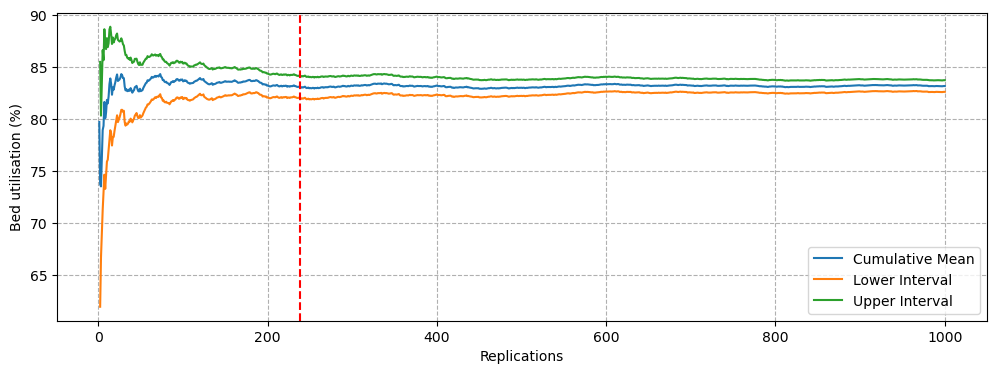

In [13]:
plot = test_trial.plot_util_conf_ints()